In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

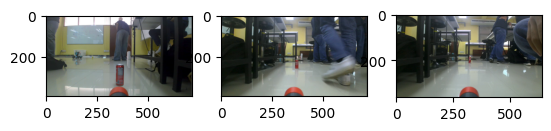

In [2]:
# อ่านภาพสีด้วย OpenCV
img1_bgr = cv2.imread('img/box1.png', cv2.IMREAD_COLOR)
img2_bgr = cv2.imread('img/box2.png', cv2.IMREAD_COLOR)
img3_bgr = cv2.imread('img/box3.png', cv2.IMREAD_COLOR)

img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3_bgr, cv2.COLOR_BGR2RGB)

plt.subplot(1,3,1)
plt.imshow(img1_rgb)

plt.subplot(1,3,2)
plt.imshow(img2_rgb)

plt.subplot(1,3,3)
plt.imshow(img3_rgb)

plt.show()

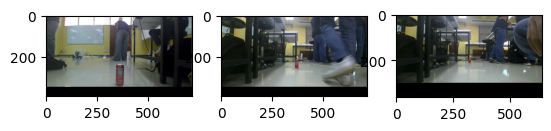

In [3]:
# กำหนดขอบ ให้พื้นที่นอกเป็น 0 
img1_rgb[350:,:] = (0,0,0)
img2_rgb[350:,:] = (0,0,0)
img3_rgb[300:,:] = (0,0,0)

plt.subplot(1,3,1)
plt.imshow(img1_rgb)

plt.subplot(1,3,2)
plt.imshow(img2_rgb)

plt.subplot(1,3,3)
plt.imshow(img3_rgb)

plt.show()

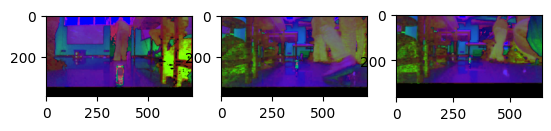

In [4]:
img1_blur = cv2.GaussianBlur(img1_rgb, (7,7), 0)
img2_blur = cv2.GaussianBlur(img2_rgb, (7,7), 0)
img3_blur = cv2.GaussianBlur(img3_rgb, (7,7), 0)

img1_hsv = cv2.cvtColor(img1_blur, cv2.COLOR_RGB2HSV)
img2_hsv = cv2.cvtColor(img2_blur, cv2.COLOR_RGB2HSV)
img3_hsv = cv2.cvtColor(img3_blur, cv2.COLOR_RGB2HSV)

plt.subplot(1,3,1)
plt.imshow(img1_hsv)

plt.subplot(1,3,2)
plt.imshow(img2_hsv)

plt.subplot(1,3,3)
plt.imshow(img3_hsv)

plt.show()

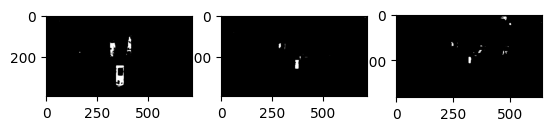

In [5]:
# Define range for red color in HSV (two ranges)
lower_red_1 = np.array([0, 50, 50], dtype=np.uint8)
upper_red_1 = np.array([10, 255, 255], dtype=np.uint8)
lower_red_2 = np.array([170, 50, 50], dtype=np.uint8)
upper_red_2 = np.array([180, 255, 255], dtype=np.uint8)

img1_bi1 = cv2.inRange(img1_hsv, lower_red_1, upper_red_1)
img1_bi2 = cv2.inRange(img1_hsv, lower_red_2, upper_red_2)
img1_bi = cv2.bitwise_or(img1_bi1, img1_bi2)

img2_bi1 = cv2.inRange(img2_hsv, lower_red_1, upper_red_1)
img2_bi2 = cv2.inRange(img2_hsv, lower_red_2, upper_red_2)
img2_bi = cv2.bitwise_or(img2_bi1, img2_bi2)

img3_bi1 = cv2.inRange(img3_hsv, lower_red_1, upper_red_1)
img3_bi2 = cv2.inRange(img3_hsv, lower_red_2, upper_red_2)
img3_bi = cv2.bitwise_or(img3_bi1, img3_bi2)

plt.subplot(1,3,1)
plt.imshow(img1_bi, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(img2_bi, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(img3_bi, cmap='gray')

plt.show()

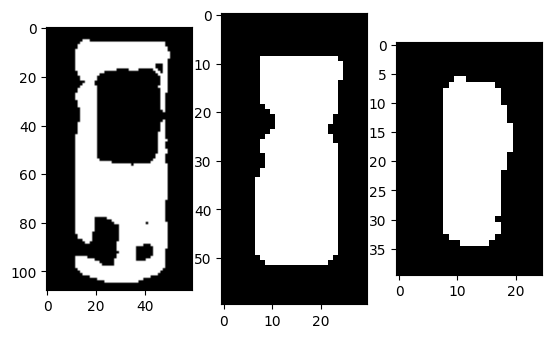

In [6]:
mask1 = img1_bi[240:348,330:390]
mask2 = img2_bi[210:270,355:385]
mask3 = img3_bi[180:220,310:335]

plt.subplot(1,3,1)
plt.imshow(mask1, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(mask2, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(mask3, cmap='gray')

plt.show()

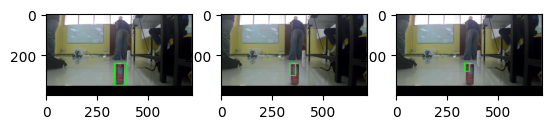

In [7]:
# ใช้ mask ที่ครอปมาเป็น template matching หาตำแหน่งลูกบอลสีส้มในภาพต้นฉบับ
result1 = cv2.matchTemplate(img1_bi, mask1, cv2.TM_CCOEFF_NORMED) # วนหาลูกบอล
result2 = cv2.matchTemplate(img1_bi, mask2, cv2.TM_CCOEFF_NORMED)
result3 = cv2.matchTemplate(img1_bi, mask3, cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result1) # หาจุดเหมือนสุด
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result2)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result3)

# สร้างสีเหลียม
top_left = max_loc
h1, w1 = mask1.shape
bottom_right1 = (top_left[0] + w1, top_left[1] + h1)

h2, w2 = mask2.shape
bottom_right2 = (top_left[0] + w2, top_left[1] + h2)

h3, w3 = mask3.shape
bottom_right3 = (top_left[0] + w3, top_left[1] + h3)


img_with_box1 = img1_rgb.copy()  # copy ภาพเพื่อแสดงภาพที่จะวาดสีเหลียม
img_with_box2 = img1_rgb.copy()
img_with_box3 = img1_rgb.copy()

plt.subplot(1,3,1)
cv2.rectangle(img_with_box1, top_left, bottom_right1, (0, 255, 0), 3) # วาดสีเหลียม
plt.imshow(img_with_box1)

plt.subplot(1,3,2)
cv2.rectangle(img_with_box2, top_left, bottom_right2, (0, 255, 0), 3) # วาดสีเหลียม
plt.imshow(img_with_box2)

plt.subplot(1,3,3)
cv2.rectangle(img_with_box3, top_left, bottom_right3, (0, 255, 0), 3) # วาดสีเหลียม
plt.imshow(img_with_box3)

plt.show()